# Install Library

In [1]:
%%time

!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 8.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=c9950a68f88814c5ad5e0647a710a436f563cb1f6247780cb7a567514c28f7ae
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
CPU times: user 203 ms, sys: 43.1 ms, total: 246 ms
Wall time: 16.7 s


In [2]:
%%time

!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 961.4 kB/s eta 0:00:00:010:00:01
CPU times: user 135 ms, sys: 44.5 ms, total: 180 ms
Wall time: 12.3 s


In [3]:
%%time

!pip install num2words

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.5 MB/s eta 0:00:00a 0:00:01
CPU times: user 135 ms, sys: 38.1 ms, total: 174 ms
Wall time: 12.2 s


# Load Files

In [4]:
%%time

import warnings
warnings.filterwarnings('ignore')

CPU times: user 40 µs, sys: 11 µs, total: 51 µs
Wall time: 52.7 µs


In [5]:
%%time

# basic imports:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import re
from datasets import load_dataset, Dataset

# NLTK, num2words, lemmatizer, stemmer, autocorrect imports:
from num2words import num2words
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

# ML imports:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import LabelEncoder

# DL imports:
from transformers import AutoTokenizer, TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import evaluate

CPU times: user 12.8 s, sys: 2.01 s, total: 14.8 s
Wall time: 36.9 s


In [6]:
%%time

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

In [7]:
%%time

# Configuration for dataset
config_dict = {
    'num_chosen_features_per_class': 200,  # Adjust based on needs
    'test_size': 0.25,  # Train/test split ratio
    'feature_eng_details': "CountVectorizer-binary",  # Feature engineering method
    'ngram_range_min': 1,
    'ngram_range_max': 3,  # Using n-grams from 1 to 3
    'max_features': 1000,  # Maximum features for CountVectorizer
    'seed': 0  # Seed for reproducibility
}

# Deep learning training parameters (Hugging Face Transformers)

lm_training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,                   # Reduce the number of epochs to 1 for faster training
    per_device_train_batch_size=16,        # The batch size to 16
    learning_rate=2e-5,                    # The same learning rate
    evaluation_strategy="steps",           # Evaluate during training at certain intervals
    logging_steps=100,                     # Log every 100 steps
    eval_steps=500,                        # Evaluate less frequently 
    gradient_accumulation_steps=2,         # Accumulate gradients for larger effective batch size
    fp16=True,                             # Enable mixed precision for faster training on GPUs
    save_steps=1000,                       # Save model checkpoint less frequently to reduce overhead
    load_best_model_at_end=True            # Load the best model after training for optimal results
)

# Optional: Specify layers to fine-tune
layers_to_fine_tune = None

# Setting display options for pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

CPU times: user 13.2 ms, sys: 59.1 ms, total: 72.3 ms
Wall time: 118 ms


In [8]:
%%time

content = pd.read_csv('/kaggle/input/learning-equality-curriculum-recommendations/content.csv')
topics_data = pd.read_csv('/kaggle/input/learning-equality-curriculum-recommendations/topics.csv')
correlation = pd.read_csv('/kaggle/input/learning-equality-curriculum-recommendations/correlations.csv')
sample_submission = pd.read_csv('/kaggle/input/learning-equality-curriculum-recommendations/sample_submission.csv')

CPU times: user 11.8 s, sys: 1.36 s, total: 13.1 s
Wall time: 25.6 s


In [9]:
%%time

topics_data.head()

CPU times: user 301 µs, sys: 0 ns, total: 301 µs
Wall time: 301 µs


,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват намаление в отклонението, когато се свържат последователно с нашия измервателен уред.",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 ниво),Научи повече за графиките на сложните показателни функции от вида y=a*b^(x+c)+d.,000cf7,source,4,bg,t_e2452e21d252,True


In [10]:
%%time

topics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76972 entries, 0 to 76971
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           76972 non-null  object
 1   title        76970 non-null  object
 2   description  34953 non-null  object
 3   channel      76972 non-null  object
 4   category     76972 non-null  object
 5   level        76972 non-null  int64 
 6   language     76972 non-null  object
 7   parent       76801 non-null  object
 8   has_content  76972 non-null  bool  
dtypes: bool(1), int64(1), object(7)
memory usage: 4.8+ MB
CPU times: user 62.4 ms, sys: 2.12 ms, total: 64.5 ms
Wall time: 80.8 ms


In [11]:
%%time

# Check for missing values in the topics data
missing_values = topics_data.isnull().sum()

missing_values

CPU times: user 50.7 ms, sys: 2.6 ms, total: 53.3 ms
Wall time: 51.9 ms


id                 0
title              2
description    42019
channel            0
category           0
level              0
language           0
parent           171
has_content        0
dtype: int64

In [12]:
%%time

# Fill missing text data with 'unknown' 
topics_data['title'].fillna('unknown', inplace=True)
topics_data['description'].fillna('unknown', inplace=True)
topics_data['parent'].fillna('unknown', inplace=True)

CPU times: user 26 ms, sys: 3 ms, total: 29 ms
Wall time: 28.3 ms


In [13]:
%%time

# Preprocess text columns by converting to lowercase
topics_data['title'] = topics_data['title'].str.lower()
topics_data['description'] = topics_data['description'].str.lower()

CPU times: user 94.2 ms, sys: 11.9 ms, total: 106 ms
Wall time: 105 ms


In [14]:
%%time

# Initialize the stemmer
stemmer = PorterStemmer()

# Apply stemming to the text columns
topics_data['title'] = topics_data['title'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
topics_data['description'] = topics_data['description'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

CPU times: user 35.4 s, sys: 0 ns, total: 35.4 s
Wall time: 35.4 s


In [15]:
%%time

# Encoding the 'category' column
label_encoder = LabelEncoder()

# Apply label encoding to the category column (target)
topics_data['category_encoded'] = label_encoder.fit_transform(topics_data['category'])

# Apply for channel & language
topics_data['channel_encoded'] = label_encoder.fit_transform(topics_data['channel'])
topics_data['language_encoded'] = label_encoder.fit_transform(topics_data['language'])

CPU times: user 66.6 ms, sys: 0 ns, total: 66.6 ms
Wall time: 64.6 ms


# Train BERT With Labeled Data

In [16]:
%%time

# Load the tokenizer and the pre-trained Language Model
labels = list(topics_data["category_encoded"].unique())

CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 2.75 ms


In [17]:
%%time

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
language_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 876 ms, sys: 682 ms, total: 1.56 s
Wall time: 7.62 s


In [18]:
%%time

# Create a DataFrame 
dataset_df = topics_data[['description', 'category_encoded']].copy()

CPU times: user 6.58 ms, sys: 1.83 ms, total: 8.41 ms
Wall time: 9.77 ms


In [19]:
%%time

# Split the dataset into train and test sets
train_df, test_df = train_test_split(dataset_df, test_size=config_dict["test_size"], random_state=config_dict['seed'])

CPU times: user 8.38 ms, sys: 0 ns, total: 8.38 ms
Wall time: 11.3 ms


In [20]:
%%time

# Further split the training set into "just train" and "training evaluation" sets
train_train_df, train_eval_df = train_test_split(train_df, test_size=config_dict["test_size"], random_state=config_dict['seed'])

CPU times: user 9.54 ms, sys: 36 µs, total: 9.58 ms
Wall time: 8.71 ms


In [21]:
%%time

# Convert the DataFrames to a Dataset format for Hugging Face Transformers
dataset_train_train = Dataset.from_pandas(train_train_df)
dataset_train_eval = Dataset.from_pandas(train_eval_df)
dataset_test = Dataset.from_pandas(test_df)

CPU times: user 80.8 ms, sys: 39.2 ms, total: 120 ms
Wall time: 147 ms


In [22]:
%%time

def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples["description"], padding="max_length", truncation=True)
    # Add labels to the tokenized inputs so the model can compute the loss
    tokenized_inputs["labels"] = examples["category_encoded"]
    return tokenized_inputs

# Tokenize the datasets
train_train_tokenized = dataset_train_train.map(tokenize_function, batched=True)
train_eval_tokenized = dataset_train_eval.map(tokenize_function, batched=True)
test_tokenized = dataset_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/43296 [00:00<?, ? examples/s]

Map:   0%|          | 0/14433 [00:00<?, ? examples/s]

Map:   0%|          | 0/19243 [00:00<?, ? examples/s]

CPU times: user 40 s, sys: 673 ms, total: 40.7 s
Wall time: 30 s


In [23]:
%%time

# Choose which neural network layers to fine-tune

if layers_to_fine_tune == "head":
    print("Fine-tuning only the classification head!")
    language_model.train()
    for name, param in language_model.named_parameters():
          # Freeze parameters of all layers except classifier head:
        if 'classifier' not in name:
            param.requires_grad = False
else:
    print("Fine-tuning the entire neural network!")

Fine-tuning the entire neural network!
CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 62.9 µs


In [24]:
%%time

# Define the compute_metrics function for F2 score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate the F2 score using sklearn's fbeta_score
    f2_score = fbeta_score(labels, predictions, beta=2, average="weighted")  # Use "weighted" for multi-class tasks
    
    return {"f2": f2_score}

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.34 µs


In [25]:
%%time

# Trainer initialization with early stopping
trainer = Trainer(
    model=language_model,
    args=lm_training_args,
    train_dataset=train_train_tokenized,
    eval_dataset=train_eval_tokenized,        # Evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,        # Metrics function for evaluation
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Early stopping
)

CPU times: user 864 ms, sys: 208 ms, total: 1.07 s
Wall time: 2.08 s


In [26]:
%%time

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F2
500,0.775500,0.771593,0.547386


CPU times: user 39min 17s, sys: 1min 21s, total: 40min 39s
Wall time: 39min 11s


TrainOutput(global_step=676, training_loss=0.8061523719652165, metrics={'train_runtime': 2351.1311, 'train_samples_per_second': 18.415, 'train_steps_per_second': 0.288, 'total_flos': 1.1383338904584192e+16, 'train_loss': 0.8061523719652165, 'epoch': 0.9992609016999261})

In [27]:
%%time 

# Converting the training log to a dataframe for plotting
training_logs_df = pd.DataFrame(trainer.state.log_history).groupby("step", as_index=False).first()

CPU times: user 117 µs, sys: 4.94 ms, total: 5.06 ms
Wall time: 13.2 ms


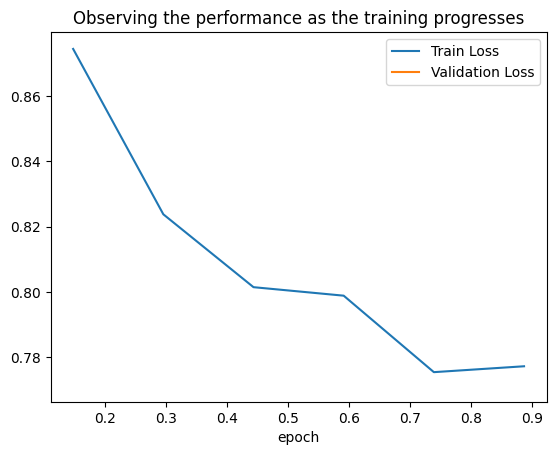

CPU times: user 655 ms, sys: 300 ms, total: 955 ms
Wall time: 911 ms


In [28]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns

training_logs_df.plot(x="epoch", y=["loss", "eval_loss"])
plt.title('Observing the performance as the training progresses')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [29]:
%%time

# Calculate the most frequent class in the training set
most_frequent_class = train_train_df["category_encoded"].mode()[0]  # Find the most frequent class

# Create baseline predictions
baseline_predictions = [most_frequent_class] * len(train_train_df)

# Calculate the baseline accuracy (predicting the most frequent class)
baseline_accuracy_dl_train = np.mean(baseline_predictions == train_train_df["category_encoded"])

# Use the trained model to predict on the training data
results_train_train = trainer.predict(train_train_tokenized)
predictions_train_train = np.argmax(results_train_train[0], axis=-1)

# Calculate the accuracy of the trained model
accuracy_dl_train = np.mean(predictions_train_train == train_train_df["category_encoded"])

# Calculate the accuracy lift  
accuracy_dl_lift_train = 100 * (accuracy_dl_train / baseline_accuracy_dl_train - 1)

# Print the results 
print("Results on the train set for a DL Language Model:\n----------------------------------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_dl_train, 2))
print("Current model's accuracy:", round(accuracy_dl_train, 2))
print("The accuracy lift is:", round(accuracy_dl_lift_train, 2), "%")

Results on the train set for a DL Language Model:
----------------------------------------------------
Baseline (dummy classifier) accuracy: 0.56
Current model's accuracy: 0.61
The accuracy lift is: 7.76 %
CPU times: user 13min 59s, sys: 7.87 s, total: 14min 7s
Wall time: 12min 46s


In [30]:
%%time

# Calculate the most frequent class in the training set
most_frequent_class = train_train_df["category_encoded"].mode()[0]  # Find the most frequent class

# Create baseline predictions for the training set
baseline_predictions_train = [most_frequent_class] * len(train_train_df)

# Calculate the baseline accuracy for the training set
baseline_accuracy_dl_train = np.mean(baseline_predictions_train == train_train_df["category_encoded"])

# Calculate the most frequent class for the test set
most_frequent_class_test = test_df["category_encoded"].mode()[0]  # Find the most frequent class in the test set

# Create baseline predictions for the test set
baseline_predictions_test = [most_frequent_class_test] * len(test_df)

# Calculate the baseline accuracy for the test set
baseline_accuracy_dl_test = np.mean(baseline_predictions_test == test_df["category_encoded"])

# Use the trained model to predict on the test set
results_test = trainer.predict(test_tokenized)
predictions_test = np.argmax(results_test[0], axis=-1)

# Calculate the accuracy of the trained model on the test set 
accuracy_dl_test = np.mean(predictions_test == test_df["category_encoded"])

# Calculate the accuracy lift (relative improvement over the baseline)
accuracy_dl_lift = 100 * (accuracy_dl_test / baseline_accuracy_dl_test - 1)

# Print the results
print("Results on the test set for a DL Language Model:\n---------------------------------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_dl_test, 2))
print("Current model's accuracy:", round(accuracy_dl_test, 2))
print("The accuracy lift is:", round(accuracy_dl_lift, 2), "%")

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(test_df["category_encoded"], predictions_test))
print("\nClassification Report:")
print(classification_report(test_df["category_encoded"], predictions_test))

Results on the test set for a DL Language Model:
---------------------------------------------------
Baseline (dummy classifier) accuracy: 0.57
Current model's accuracy: 0.61
The accuracy lift is: 6.07 %

Confusion Matrix:
[[  341  3048    15]
 [  104 10811    70]
 [   36  4318   500]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.10      0.18      3404
           1       0.59      0.98      0.74     10985
           2       0.85      0.10      0.18      4854

    accuracy                           0.61     19243
   macro avg       0.72      0.40      0.37     19243
weighted avg       0.68      0.61      0.50     19243

CPU times: user 6min 7s, sys: 3.51 s, total: 6min 10s
Wall time: 5min 37s


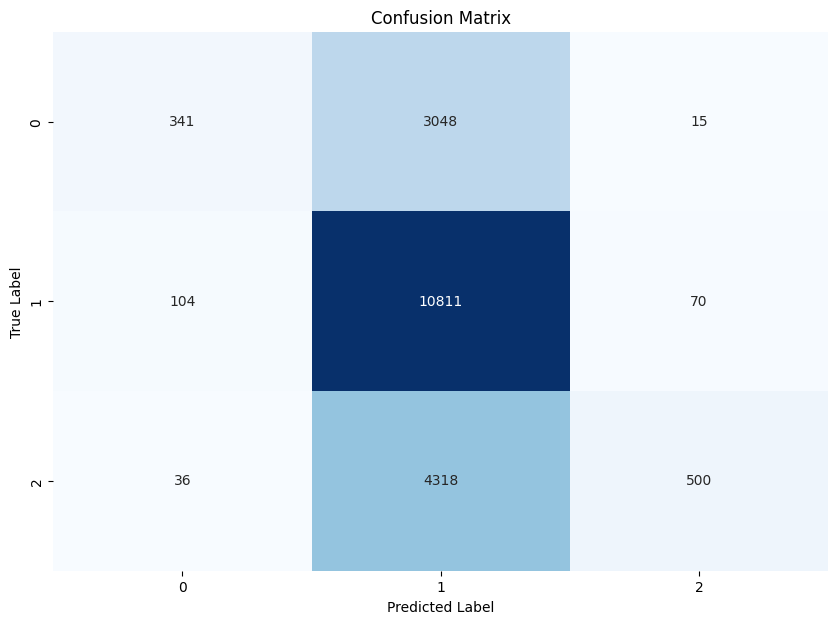

CPU times: user 264 ms, sys: 168 ms, total: 433 ms
Wall time: 164 ms


In [31]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = test_df["category_encoded"]
predicted_labels = predictions_test

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [32]:
%%time

merged_data = pd.merge(correlation, topics_data, left_on='topic_id', right_on='id', how='left')

CPU times: user 57.7 ms, sys: 22 ms, total: 79.7 ms
Wall time: 94.2 ms


In [33]:
%%time

# Tokenize

def tokenize_function(examples):
    return tokenizer(examples['description'], padding="max_length", truncation=True)

# Convert to Hugging Face Dataset and tokenize
unlabeled_dataset = Dataset.from_pandas(merged_data)
correlations_tokenized = unlabeled_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/61517 [00:00<?, ? examples/s]

CPU times: user 32 s, sys: 408 ms, total: 32.4 s
Wall time: 23.9 s


In [34]:
%%time

# Apply the tokenizer to the merged data 
correlations_tokenized = unlabeled_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/61517 [00:00<?, ? examples/s]

CPU times: user 31.8 s, sys: 368 ms, total: 32.2 s
Wall time: 23.8 s


In [35]:
%%time

# Use the trained model to predict the labels for the tokenized data 
results_correlations = trainer.predict(correlations_tokenized)

CPU times: user 19min 46s, sys: 11 s, total: 19min 57s
Wall time: 18min 6s


In [36]:
%%time

# Get the predicted labels (classes) using np.argmax to select the most likely class for each input
predictions_correlations = np.argmax(results_correlations.predictions, axis=-1)

CPU times: user 1.81 ms, sys: 0 ns, total: 1.81 ms
Wall time: 1.15 ms


In [37]:
%%time

# Map the predicted labels back to their original category names
predicted_content_ids = label_encoder.inverse_transform(predictions_correlations)

CPU times: user 3.15 ms, sys: 3 µs, total: 3.15 ms
Wall time: 2.93 ms


In [38]:
%%time

merged_data['predicted_content_ids'] = predicted_content_ids

CPU times: user 1.44 ms, sys: 10 µs, total: 1.45 ms
Wall time: 1.24 ms


In [39]:
%%time

# Save the correlations DataFrame with predicted labels to a CSV
merged_data[['topic_id', 'predicted_content_ids']].to_csv('submission.csv', index=False)

CPU times: user 92.3 ms, sys: 1.01 ms, total: 93.3 ms
Wall time: 98 ms


In [40]:
%%time  

correlation.head()

CPU times: user 179 µs, sys: 5 µs, total: 184 µs
Wall time: 181 µs


,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c_76231f9d0b5e
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c_ebb7fdf10a7e
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c_b972646631cb c_d7a0d7eaf799
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4
